Importing the necessary libraries

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,classification_report
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('preprocessed_data_.csv')

In [ ]:
# Print value counts of the target column
target_column = 'Study_Status_Updated'  # Replace with your target column name
value_counts = df[target_column].value_counts()
print(value_counts)

Study_Status_Updated
0    221243
1     36334
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Convert categorical variables to numerical using Label Encoding
label_encoders = {}
for column in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [ ]:
# Define features and target
X = df.drop(['Study_Status_Updated','Status_Explanation','Study Results','Study Status'], axis=1)  # Features
y = df['Study_Status_Updated']  # Target

In [ ]:
# Check if X and y have consistent lengths
if len(X) != len(y):
    raise ValueError(f"Inconsistent lengths: X={len(X)}, y={len(y)}")

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(f"Resampled X_train shape: {X_train_resampled.shape}, Resampled y_train length: {len(y_train_resampled)}")

Resampled X_train shape: (353988, 434), Resampled y_train length: 353988


In [ ]:
# Standardize the data (optional, based on the nature of the features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# XGBoost


XGBoost is an optimized gradient boosting algorithm designed for fast performance and high accuracy in tasks like classification and regression. It builds trees iteratively to minimize errors and handles structured data effectively.

In [ ]:
# Model building - Using XGBoost
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
# Train the model
model.fit(X_train_scaled,y_train_resampled)

C:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Model evaluation on the test set
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
aucroc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="weighted")

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"AUC-ROC: {aucroc:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.94
F1 Score: 0.94
Recall: 0.94
Precision: 0.94
AUC-ROC: 0.85
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     44249
           1       0.85      0.73      0.78      7267

    accuracy                           0.94     51516
   macro avg       0.90      0.85      0.87     51516
weighted avg       0.94      0.94      0.94     51516



The model demonstrates strong overall performance with an accuracy of 0.94 and an F1-score of 0.94, indicating a good balance between precision and recall. The model also achieves a high AUC-ROC score of 0.85, suggesting good discrimination ability in classifying between the two classes.

In [ ]:
pip install shap

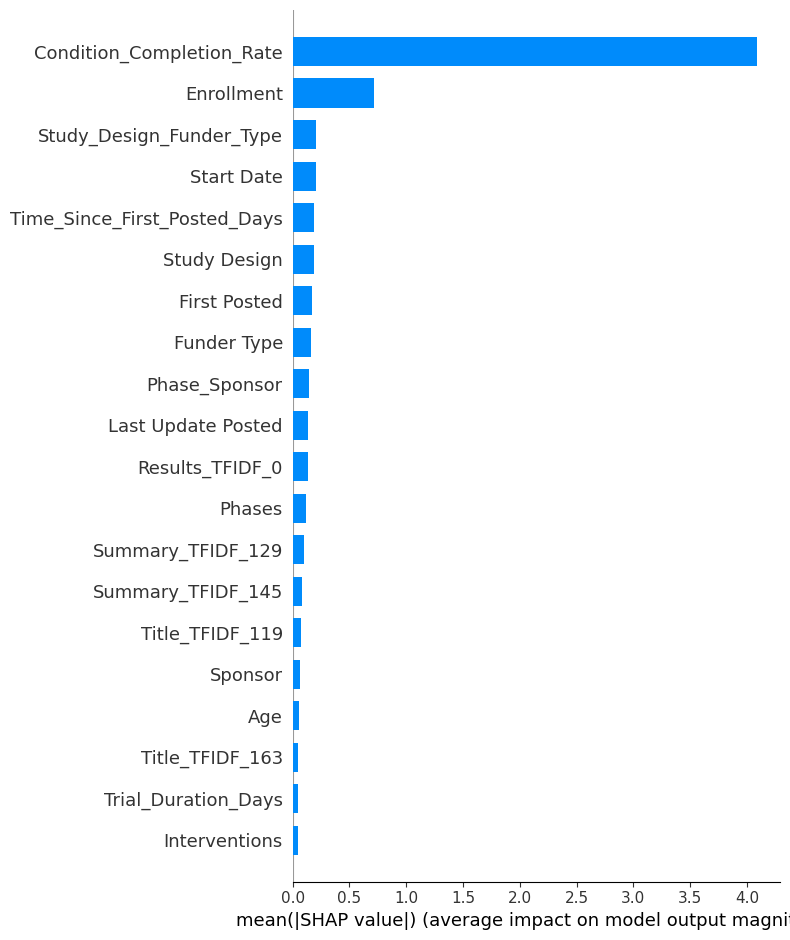

In [ ]:
import shap
import matplotlib.pyplot as plt

# Convert X_test back to a DataFrame with proper column names
X_test_df = pd.DataFrame(X_test_scaled, columns=list(X.columns))

# Initialize SHAP explainer for your XGBoost model
explainer = shap.Explainer(model)

# Compute SHAP values for the test set
shap_values = explainer(X_test_df)

# Summary plot to show feature importance
shap.summary_plot(shap_values, X_test_df, plot_type="bar")


The SHAP analysis reveals that features like "Enrollment," "Condition_Completion_Rate," and "Study_Design_Funder_Type" have a strong influence on the model's predictions, suggesting that the model is capturing important aspects of the data and may provide valuable insights into clinical trial outcomes.

In [ ]:
# Get important features from the SHAP summary plot (replace with actual feature names)
important_features = ['Condition_Completion_Rate','Enrollment', 'Study_Design_Funder_Type','Time_Since_First_Posted_Days']

# Select only the important features for training and testing
X_train_subset = X_train[important_features]
X_test_subset = X_test[important_features]

# Fit your model on the subset of features
model.fit(X_train_subset, y_train)

# Make predictions on the test set using the subset of features
y_pred_subset = model.predict(X_test_subset)

# Calculate accuracy on the test set
accuracy_subset = accuracy_score(y_test, y_pred_subset)

print(f"Accuracy on subset: {accuracy_subset:.4f}")

[12:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy on subset: 0.9473


In [ ]:
# Get important features from the SHAP summary plot (replace with actual feature names)
important_features = ['Study Design', 'Funder Type','Phase_Sponsor']

# Select only the important features for training and testing
X_train_subset = X_train[important_features]
X_test_subset = X_test[important_features]

# Fit your model on the subset of features
model.fit(X_train_subset, y_train)

# Make predictions on the test set using the subset of features
y_pred_subset = model.predict(X_test_subset)

# Calculate accuracy on the test set
accuracy_subset = accuracy_score(y_test, y_pred_subset)

print(f"Accuracy on subset: {accuracy_subset:.4f}")

[12:53:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy on subset: 0.8589


In [ ]:
import pickle
# Save the trained XGBoost model to a JSON file
model.save_model('xgboost_model.json')
# Save the StandardScaler as a pickle file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
# Save the LabelEncoders dictionary as a pickle file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [ ]:
# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
